##### RAG - RAG stands for Retrieval-Augmented Generation, a framework used in natural language processing (NLP) and AI applications to combine the strengths of information retrieval with generative models. It enhances the quality and relevance of responses by grounding the generation process in external, factual data sources.

  - Group Member Life Insurance Policy - Query Assist AI Chatbot

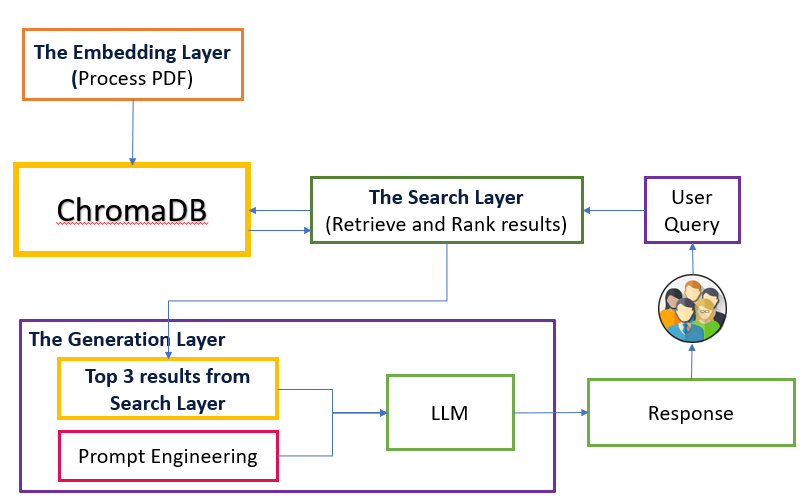

In [3]:
import openai

In [4]:
print('Reading OpenAI Key Text File')

# Remember to upload the file containing your OpenAI key. Make sure the file name is correct
with open("OPENAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())
if openai.api_key.startswith('sk-'):
    print('API key loaded successfully')
else:
  print('Improper API key format')

Reading OpenAI Key Text File
API key loaded successfully


In [5]:
# Install the following packages incase they're not loaded already
!pip install pdfplumber
!pip install chromadb==0.5.3
!pip install tiktoken
!pip install openai

In [6]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
import openai

LLM - context window

LLM(snapshot memory) --> output, question 2
LLM + external memory : added memory + added knowledge + ground your system

## Quick Recap of RAG

Quick Recap of a RAG system

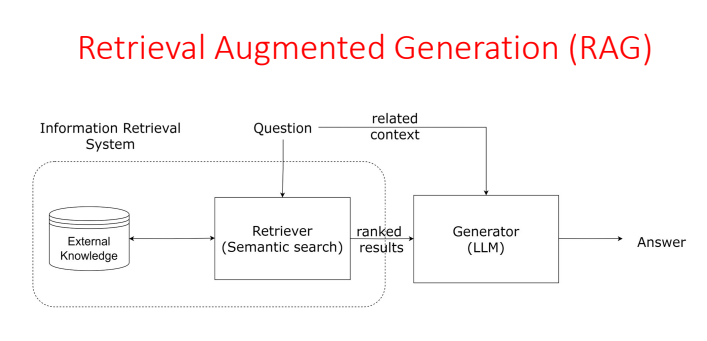

In [7]:
## Issues with normal LLMs
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":"What is the revenue of uber in 2023?"},
          ]

In [8]:
## New method (as older completion and chatcompletion endpoints have been deprecated)
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"I'm sorry, I cannot provide real-time or future financial information as I do not have access to current data. It is best to refer to official sources or reliable financial news outlets for the most up-to-date information on Uber's revenue in 2023. If you have any other questions or need assistance with something else, feel free to ask!"

As you see the LLMs may not have access to your internal data, and therefore, they won't be able to **retrieve** information beyond the data that they have been trained on

However there's a trick you can use!!

Here's the relevant snippet from uber's annual filings report uber_2021. pdf page 53

*Revenue was $17.5 billion, or up 57% year-over-year, reflecting the overall growth in our Delivery business and an increase in Freight revenue attributable tothe acquisition of Transplace in the fourth quarter of 2021 as well as growth in the number of shippers and carriers on the network combined with an increase involumes with our top shippers.*

In [9]:
retrieved = "Revenue was $10 billion, or up 57% year-over-year, reflecting the overall growth in our Delivery business and an increase in Freight revenue attributable tothe acquisition of Transplace in the fourth quarter of 2024 as well as growth in the number of shippers and carriers on the network combined with an increase involumes with our top shippers."

In [10]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2021?. Use the information presented in '{retrieved}' """},
          ]

In [11]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'The revenue of Uber in 2021 was $10 billion, which was a 57% increase compared to the previous year. This growth was driven by the overall expansion of their Delivery business, an increase in Freight revenue due to the acquisition of Transplace, and growth in the number of shippers and carriers on the network, along with increased volumes with their top shippers.'

In [12]:
messages2 = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2024?. Use the information presented in '{retrieved}' """},
          ]

In [13]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages2)
response.choices[0].message.content

'Based on the information provided, the revenue of Uber in 2024 was $10 billion, reflecting a 57% year-over-year increase. This growth was driven by the overall growth in their Delivery business, an increase in Freight revenue from the acquisition of Transplace, and growth in the number of shippers and carriers.'

So what we did above was,
- We **retrieved** the information from an external source,
- **Augmented** our query with the relevant information prompt,
- and finally we **generated** the relevant response

This above process is RAG in a nutshell!

## Starter Code explanation

### Data Processing

Quite crucial, hence suggested to use good parsers that can load the data from your documents effectively.


In [14]:
pdf_path = "pdf"

In [15]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [16]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any([check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [17]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [18]:
data

[   Page No.                                          Page_Text  \
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
 1    Page 2                 This page left blank intentionally   
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
 3    Page 4                 This page left blank intentionally   
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
 ..      ...                                                ...   
 59  Page 60  I f a Dependent who was insured dies during th...   
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
 61  Page 62  A claimant may request an appeal of a claim de...   
 62  Page 63                 This page left blank intentionally   
 63  Page 64  Principal Life Insurance Company Des Moines, I...   
 
                                  Document Name  
 0   Principal-Sample-Life-Insurance-Policy.pdf  
 1   Principal-Sample-Life-Insurance-Policy.pdf  
 2   Principal-Sample-Life-Insurance-Policy.

In [19]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [20]:
insurance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [21]:
len(insurance_pdfs_data)

64

In [32]:
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'filing_name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [22]:
insurance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


## Generate and Store Embeddings using OpenAI and ChromaDB
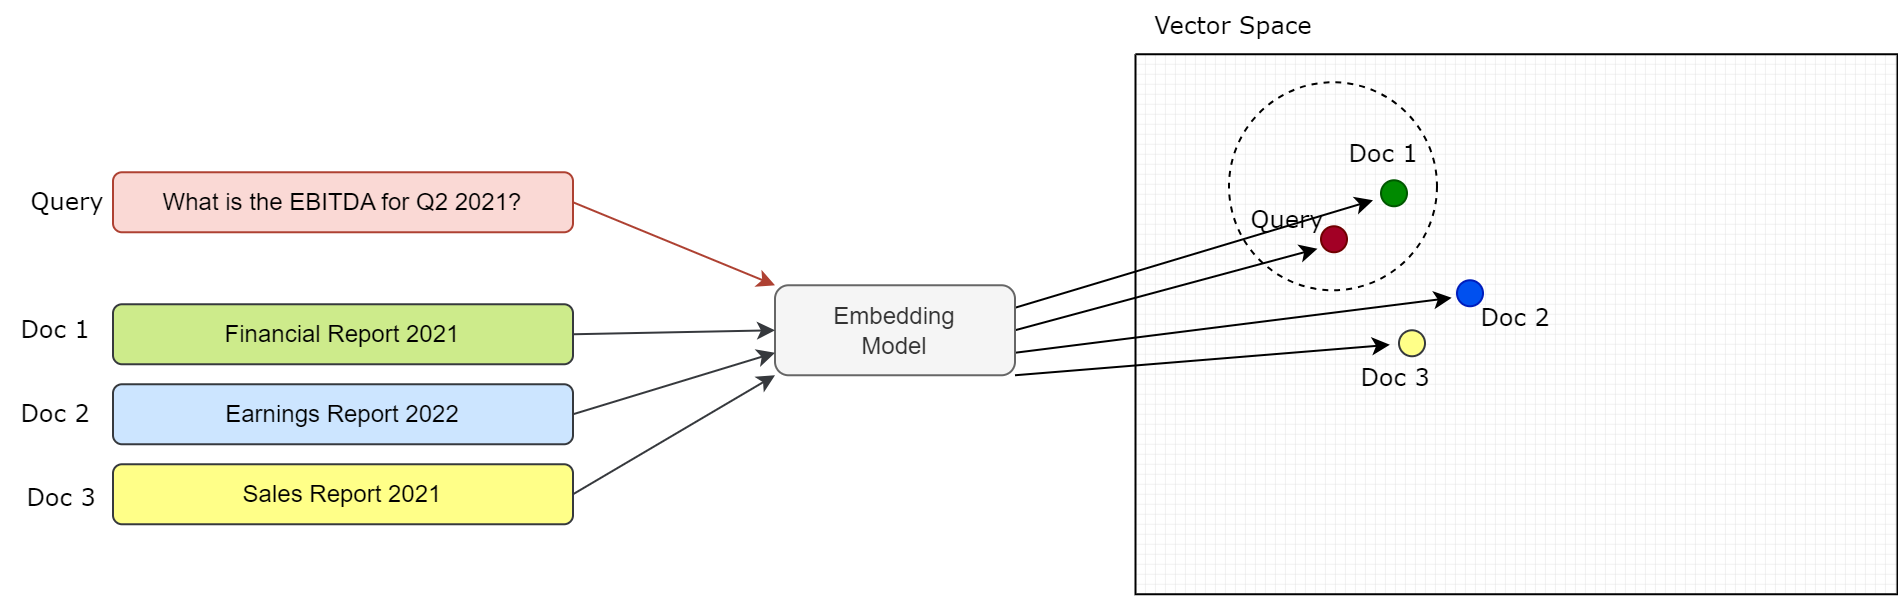

input ---> embedding model --> feature/latent vector (limited dimensions for ex)

f.v (king) f.v(man)
f.v(queen) f.v (woman)

In [23]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [24]:
# Define the path where chroma collections will be stored

chroma_data_path = "persist_path"

In [25]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [26]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [36]:
## Create an empty collection
insurance_data_collection = client.get_or_create_collection(name='RAG', embedding_function=embedding_function)

In [37]:
insurance_data_collection

- Lets examine : insurance_pdfs_data

In [33]:
documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [35]:
metadata_list

[{'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 1'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 2'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 3'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 4'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 5'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 6'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 7'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 8'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 9'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 10'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 11'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': '

In [34]:
documents_list

['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
 'This page left blank intentionally',
 'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged

In [ ]:
#metadata_list

In [38]:
?insurance_data_collection 

In [39]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_data_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [40]:
insurance_data_collection

In [41]:
insurance_data_collection.peek(2)

{'ids': ['0', '1'],
 'embeddings': [[-0.022422879934310913,
   0.01871834322810173,
   -0.027236169204115868,
   -0.03125376254320145,
   -0.0037534518633037806,
   0.027914464473724365,
   0.0009359171963296831,
   0.023622941225767136,
   -0.01653997227549553,
   0.004245868418365717,
   -0.00522417901083827,
   0.004043683875352144,
   -0.006195967551320791,
   0.023231616243720055,
   -0.011270138435065746,
   0.03096679225564003,
   0.002882755361497402,
   -0.024666473269462585,
   0.03054938092827797,
   0.007806919049471617,
   0.006401412654668093,
   0.01892705075442791,
   0.009496135637164116,
   0.012626729905605316,
   -0.012404979206621647,
   -0.009378737770020962,
   0.01788351871073246,
   -0.021653275936841965,
   0.023531632497906685,
   0.0030865701846778393,
   0.013278936967253685,
   -0.014622483402490616,
   -0.033549532294273376,
   -0.04114122316241264,
   -0.008472170680761337,
   0.013578951358795166,
   -0.002646330278366804,
   -0.0038643269799649715,
   

In [42]:
# Let's take a look at the first few entries in the collection

insurance_data_collection.get(
   ids = ['0','1','2'],
   include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022422879934310913,
   0.01871834322810173,
   -0.027236169204115868,
   -0.03125376254320145,
   -0.0037534518633037806,
   0.027914464473724365,
   0.0009359171963296831,
   0.023622941225767136,
   -0.01653997227549553,
   0.004245868418365717,
   -0.00522417901083827,
   0.004043683875352144,
   -0.006195967551320791,
   0.023231616243720055,
   -0.011270138435065746,
   0.03096679225564003,
   0.002882755361497402,
   -0.024666473269462585,
   0.03054938092827797,
   0.007806919049471617,
   0.006401412654668093,
   0.01892705075442791,
   0.009496135637164116,
   0.012626729905605316,
   -0.012404979206621647,
   -0.009378737770020962,
   0.01788351871073246,
   -0.021653275936841965,
   0.023531632497906685,
   0.0030865701846778393,
   0.013278936967253685,
   -0.014622483402490616,
   -0.033549532294273376,
   -0.04114122316241264,
   -0.008472170680761337,
   0.013578951358795166,
   -0.002646330278366804,
   -0.0038643269799649715

In [44]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [45]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'metadatas', 'documents']}

## Semantic Search with Cache

We have created 2 collections
- insurance_data_collection (embeddings are already present)
- cache_collection (an empty collection at the beginning)

Our strategy is to first check the cache_collection and see if can answer the query or not.

In case it doesn't the query then passes to the insurance_data_collection, and the query results get appended to cache_collection (embeddings, metadata, etc)

Semantic Search Pipeline

In [46]:
# Read the user query
query = input()

what are insurance policy terms?


In [47]:
query

'what are insurance policy terms?'

In [48]:
## Quickly checking the results of the query
results = insurance_data_collection.query(
      query_texts=query,
      n_results=10
      )

In [49]:
results

{'ids': [['5', '17', '16', '24', '12', '15', '20', '34', '19', '23']],
 'distances': [[0.32397300139586566,
   0.3316212536386385,
   0.33528544410692773,
   0.3530259078459304,
   0.3531949494897349,
   0.3533069879281927,
   0.3605285470016995,
   0.3671536596811098,
   0.36894718976474383,
   0.37325105715526635]],
 'metadatas': [[{'Page_No.': 'Page 6',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 18',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 17',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 25',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 13',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 16',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 21',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 35',
    'filing_name':

In [50]:
for key, val in results.items():
  print(key)

ids
distances
metadatas
embeddings
documents
uris
data
included


In [51]:
for key, val in results.items():
  print(key)
  print(val)

ids
[['5', '17', '16', '24', '12', '15', '20', '34', '19', '23']]
distances
[[0.32397300139586566, 0.3316212536386385, 0.33528544410692773, 0.3530259078459304, 0.3531949494897349, 0.3533069879281927, 0.3605285470016995, 0.3671536596811098, 0.36894718976474383, 0.37325105715526635]]
metadatas
[[{'Page_No.': 'Page 6', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 18', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 17', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 25', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 13', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 16', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 21', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 35', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 20', 'filing_name': 'Principal-

In [52]:
results

{'ids': [['5', '17', '16', '24', '12', '15', '20', '34', '19', '23']],
 'distances': [[0.32397300139586566,
   0.3316212536386385,
   0.33528544410692773,
   0.3530259078459304,
   0.3531949494897349,
   0.3533069879281927,
   0.3605285470016995,
   0.3671536596811098,
   0.36894718976474383,
   0.37325105715526635]],
 'metadatas': [[{'Page_No.': 'Page 6',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 18',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 17',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 25',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 13',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 16',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 21',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 35',
    'filing_name':

In [ ]:
for key, val in results.items():
  if key not in ['embeddings', 'uris','data']:
    for i in range(10):
      print(str(key)+str(i))


ids0
ids1
ids2
ids3
ids4
ids5
ids6
ids7
ids8
ids9
distances0
distances1
distances2
distances3
distances4
distances5
distances6
distances7
distances8
distances9
metadatas0
metadatas1
metadatas2
metadatas3
metadatas4
metadatas5
metadatas6
metadatas7
metadatas8
metadatas9
documents0
documents1
documents2
documents3
documents4
documents5
documents6
documents7
documents8
documents9
included0
included1
included2
included3
included4
included5
included6
included7
included8
included9


Building the cache

In [54]:
# Searh the Cache collection first
# Query the collection against the user query and return the top result

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [['what is the revenue for uber in 2021?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.291570782661438',
    'distances1': '0.291890025138855',
    'distances2': '0.3001808226108551',
    'distances3': '0.3090325593948364',
    'distances4': '0.30984553694725037',
    'distances5': '0.33668458461761475',
    'distances6': '0.3538624048233032',
    'distances7': '0.36195850372314453',
    'distances8': '0.36280930042266846',
    'documents0': 'Financial and Operational Highlights Year Ended December 31, Constant Currency (1) [[null, null, null, null, null, null, null, null, null, null, null, "2020 to 2021 % Change", null], ["Monthly Active Platform Consumers (\\u201cMAPCs\\u201d) (2), (3)", "", "93", null, "", "118", null, "", "27", "%", "", "", null], ["Trips (2)", "", "5,025", null, "", "6,368", null, "", "27", "%", "", "", null], ["Gross Bookings (2)", "", "$", "57,897", "", "$", "90,415", "", "56", "%", "", "53", "%"], [null, "", "$", "11,139", "", "$", "17,45

In [55]:
cache_results['distances'][0]

[]

In [57]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_data_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if key not in ['embeddings', 'uris','data']:
          for i in range(9):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Not found in cache. Found in main collection.


In [58]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 6', 'filing_name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.323973,5
1,"{'Page_No.': 'Page 18', 'filing_name': 'Princi...",c . a copy of the form which contains the stat...,0.331621,17
2,"{'Page_No.': 'Page 17', 'filing_name': 'Princi...",a. be actively engaged in business for profit ...,0.335285,16
3,"{'Page_No.': 'Page 25', 'filing_name': 'Princi...",Section D - Policy Renewal Article 1 - Renewal...,0.353026,24
4,"{'Page_No.': 'Page 13', 'filing_name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.353195,12
5,"{'Page_No.': 'Page 16', 'filing_name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.353307,15
6,"{'Page_No.': 'Page 21', 'filing_name': 'Princi...",b . on any date the definition of Member or De...,0.360529,20
7,"{'Page_No.': 'Page 35', 'filing_name': 'Princi...",Section C - Individual Terminations Article 1 ...,0.367154,34
8,"{'Page_No.': 'Page 20', 'filing_name': 'Princi...",Section B - Premiums Article 1 - Payment Respo...,0.368947,19
9,"{'Page_No.': 'Page 24', 'filing_name': 'Princi...",T he Principal may terminate the Policyholder'...,0.373251,23


In [60]:
## Checking if the cache also contains the results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)
cache_results

{'ids': [['what are insurance policy terms?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.32397300139586566',
    'distances1': '0.3316212536386385',
    'distances2': '0.33528544410692773',
    'distances3': '0.3530259078459304',
    'distances4': '0.3531949494897349',
    'distances5': '0.3533069879281927',
    'distances6': '0.3605285470016995',
    'distances7': '0.3671536596811098',
    'distances8': '0.36894718976474383',
    'documents0': 'TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates A

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

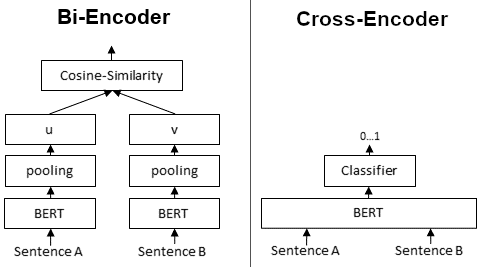

<br>

In [61]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 9.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.5/408.5 kB 8.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [62]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [63]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [64]:
# Test the cross encoder model

scores = cross_encoder.predict([['what are insurance policy terms?', 'Individual Terminations Article'],
                                ['what are insurance policy terms?', 'Premiums Article']])

In [65]:
scores

array([-10.9394  , -10.090195], dtype=float32)

In [66]:
# Test the cross encoder model

scores = cross_encoder.predict([['what are insurance policy terms?', 'Individual needs to pay Premiums on time'],
                                ['what are insurance policy terms?', ' Any Article']])
scores

array([-10.51952 ,  -9.952723], dtype=float32)

In [67]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [68]:
 #Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [69]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 6', 'filing_name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.323973,5,-9.538326
1,"{'Page_No.': 'Page 18', 'filing_name': 'Princi...",c . a copy of the form which contains the stat...,0.331621,17,-3.792260
2,"{'Page_No.': 'Page 17', 'filing_name': 'Princi...",a. be actively engaged in business for profit ...,0.335285,16,-5.571726
3,"{'Page_No.': 'Page 25', 'filing_name': 'Princi...",Section D - Policy Renewal Article 1 - Renewal...,0.353026,24,-5.170661
4,"{'Page_No.': 'Page 13', 'filing_name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.353195,12,-5.240391
5,"{'Page_No.': 'Page 16', 'filing_name': 'Princi...",PART II - POLICY ADMINISTRATION Section A - Co...,0.353307,15,-5.488846
6,"{'Page_No.': 'Page 21', 'filing_name': 'Princi...",b . on any date the definition of Member or De...,0.360529,20,-4.954389
7,"{'Page_No.': 'Page 35', 'filing_name': 'Princi...",Section C - Individual Terminations Article 1 ...,0.367154,34,-5.948782
8,"{'Page_No.': 'Page 20', 'filing_name': 'Princi...",Section B - Premiums Article 1 - Payment Respo...,0.368947,19,-6.166229
9,"{'Page_No.': 'Page 24', 'filing_name': 'Princi...",T he Principal may terminate the Policyholder'...,0.373251,23,-9.634761


In [70]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 6', 'filing_name': 'Princip...",TABLE OF CONTENTS PART I - DEFINITIONS PART II...,0.323973,5,-9.538326
1,"{'Page_No.': 'Page 18', 'filing_name': 'Princi...",c . a copy of the form which contains the stat...,0.331621,17,-3.792260
2,"{'Page_No.': 'Page 17', 'filing_name': 'Princi...",a. be actively engaged in business for profit ...,0.335285,16,-5.571726


In [71]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [72]:
top_3_RAG

,Documents,Metadatas
1,c . a copy of the form which contains the stat...,"{'Page_No.': 'Page 18', 'filing_name': 'Princi..."
6,b . on any date the definition of Member or De...,"{'Page_No.': 'Page 21', 'filing_name': 'Princi..."
3,Section D - Policy Renewal Article 1 - Renewal...,"{'Page_No.': 'Page 25', 'filing_name': 'Princi..."


In [73]:
top_3_RAG['Documents'].iloc[0]

"c . a copy of the form which contains the statement is given to the insured or the insured's beneficiary at the time insurance is contested. However, these provisions will not preclude the assertion at any time of defenses based upon the person's ineligibility for insurance under this Group Policy or upon the provisions of this Group Policy. In addition, if an individual's age is misstated, The Principal may at any time adjust premium and benefits to reflect the correct age. Article 6 - Information to be Furnished The Policyholder must, upon request, give The Principal all information needed to administer this Group Policy. If a clerical error is found in this information, The Principal may at any time adjust premium to reflect the facts. An error will not invalidate insurance that would otherwise be in force. Neither will an error continue insurance that would otherwise be terminated. The Principal may inspect, at any reasonable time, all Policyholder records, which relate to this Gr

## Build the RAG system

In [74]:
retrieved = top_3_RAG['Documents'].iloc[0]

In [75]:
query

'what are insurance policy terms?'

In [76]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""{query}. You need to use the provided information extracted from the filing report of 2021 in'{retrieved}' """},
          ]

In [77]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"Insurance policy terms refer to the specific conditions, provisions, and rules outlined in an insurance policy contract that both the insured and insurer must adhere to. These terms can include details about coverage, premiums, benefits, limitations, exclusions, and procedures for filing claims. In the provided information extracted from the filing report of 2021 in'C, several key policy terms are highlighted:\n\n1. Contestability: In case of a dispute or contestation of the insurance, the relevant statement is provided to the insured or their beneficiary. However, this does not prevent the insurer from asserting defenses based on the person's eligibility for the insurance or the policy provisions.\n\n2. Premium Adjustment: The insurer may adjust the premium and benefits if an individual's age is misstated in the policy information. This adjustment will reflect the correct age of the insured.\n\n3. Information Furnishing: The policyholder is required to provide all necessary informati

Next steps for you

- The above prompt is a very simplistic one. Build a robust prompt template that can give you the search results, along with citations (Page No, metadata, etc)

- Test out the prompt results thoroughly,
- Modularize the different parts from semantic search section onwards. There can be better and more systematic pipelines.

In [78]:
messages3 = [
    {"role":"system", "content":"You are an AI assistant to user looking specifically on insurance related documents."},
    {"role":"user", "content":f"""{query}. You need to use the provided information extracted from the policy document in'{retrieved}' """},
          ]

In [79]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages3)
response.choices[0].message.content

"Insurance policy terms are the specific provisions and conditions outlined in an insurance policy document that detail the rights, obligations, and coverage offered to the insured party. These terms may include provisions related to contestability, eligibility, premium adjustments, information disclosure, issuance of certificates, assignments, dependent rights, and policy interpretation. \n\nBased on the provided information from the document:\n\n- Contestability: A copy of the form containing the statement is given to the insured or the insured's beneficiary when insurance is contested. Defenses based on ineligibility or policy provisions can be asserted at any time.\n- Premium Adjustment: The insurer may adjust premiums and benefits if an individual's age is misstated, and the Policyholder must provide accurate information upon request.\n- Information Disclosure: The Policyholder must provide all necessary information for policy administration, and any clerical errors may result in 

In [ ]:
pdf

left --word------sentence------para--------pages-----pdf---right